In [121]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import nibabel as nb
from linescanning import pycortex,utils,optimal,glm
from scipy.optimize import curve_fit
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import seaborn as sns
opj = os.path.join

iMoco_dir = '/data1/projects/MicroFunc/Jurjen/projects/Development/2021_08_20'
tsv_file = opj(iMoco_dir, 'task', 'sub-999_run-1_task-LR_events.tsv')

In [122]:
data_onsets = []
with open(tsv_file) as f:
    timings = pd.read_csv(f, delimiter='\t')
    data_onsets.append(pd.DataFrame(timings))

data = data_onsets[0]
data.head(10)

,trial_nr,onset,event_type,phase,response,nr_frames,condition,fix_color_changetime,onset_abs,duration
0,0,0.006970,stim,0,NaN,131.0,NaN,NaN,0.992293,1.091660
1,0,1.090515,response,0,space,NaN,NaN,NaN,2.075839,NaN
2,1,1.098630,stim,0,NaN,78154.0,NaN,NaN,2.083954,651.295773
3,1,652.387805,pulse,0,t,NaN,NaN,NaN,653.373129,NaN
4,1,652.394403,stim,1,NaN,2881.0,NaN,NaN,653.379727,24.008793
5,1,675.586661,pulse,1,t,NaN,NaN,NaN,676.571985,NaN
6,2,676.403196,iti,0,NaN,1094.0,right,1.221098,677.388520,9.116843
7,2,677.169988,pulse,0,t,NaN,right,1.221098,678.155312,NaN
8,2,685.520040,stim,1,NaN,90.0,right,1.221098,686.505363,0.750012
9,3,686.270052,iti,0,NaN,553.0,right,0.207814,687.255375,4.608426


In [3]:
start_times = pd.DataFrame(data[(data['response'] == 't') & (data['trial_nr'] == 1) & (data['phase'] == 0)][['onset']])
data_cut_start = data.drop([q for q in np.arange(0,start_times.index[0])])
data_cut_start.head(10)

,trial_nr,onset,event_type,phase,response,nr_frames,condition,fix_color_changetime,onset_abs,duration
3,1,652.387805,pulse,0,t,NaN,NaN,NaN,653.373129,NaN
4,1,652.394403,stim,1,NaN,2881.0,NaN,NaN,653.379727,24.008793
5,1,675.586661,pulse,1,t,NaN,NaN,NaN,676.571985,NaN
6,2,676.403196,iti,0,NaN,1094.0,right,1.221098,677.388520,9.116843
7,2,677.169988,pulse,0,t,NaN,right,1.221098,678.155312,NaN
8,2,685.520040,stim,1,NaN,90.0,right,1.221098,686.505363,0.750012
9,3,686.270052,iti,0,NaN,553.0,right,0.207814,687.255375,4.608426
10,3,690.878478,stim,1,NaN,90.0,right,0.207814,691.863801,0.750077
11,4,691.628555,iti,0,NaN,754.0,left,4.246258,692.613879,6.283456
12,4,697.912010,stim,1,NaN,90.0,left,4.246258,698.897334,0.750013


In [260]:
t_times = pd.DataFrame(data[(data['response'] == 't')])
t_times.head(10)

,trial_nr,onset,event_type,phase,response,nr_frames,condition,fix_color_changetime,onset_abs,duration
3,1,652.387805,pulse,0,t,NaN,NaN,NaN,653.373129,NaN
5,1,675.586661,pulse,1,t,NaN,NaN,NaN,676.571985,NaN
7,2,677.169988,pulse,0,t,NaN,right,1.221098,678.155312,NaN
14,5,700.237105,pulse,0,t,NaN,left,1.094465,701.222428,NaN
15,5,701.820465,pulse,0,t,NaN,left,1.094465,702.805789,NaN
20,7,724.888111,pulse,0,t,NaN,left,0.685615,725.873435,NaN
21,7,726.470946,pulse,0,t,NaN,left,0.685615,727.456270,NaN
30,11,749.546423,pulse,0,t,NaN,left,1.680933,750.531747,NaN
31,11,751.121412,pulse,0,t,NaN,left,1.680933,752.106736,NaN
39,14,774.196868,pulse,1,t,NaN,left,5.086990,775.182192,NaN


In [261]:
t_times.tail(10)

,trial_nr,onset,event_type,phase,response,nr_frames,condition,fix_color_changetime,onset_abs,duration
96,36,923.683718,pulse,1,t,NaN,right,1.085310,924.669041,NaN
103,39,946.758545,pulse,1,t,NaN,right,5.036175,947.743868,NaN
105,40,948.341932,pulse,0,t,NaN,right,3.687707,949.327256,NaN
111,42,971.409038,pulse,1,t,NaN,left,5.825918,972.394362,NaN
113,43,972.992444,pulse,0,t,NaN,left,4.169456,973.977767,NaN
120,46,996.067932,pulse,0,t,NaN,left,0.330128,997.053256,NaN
121,46,997.642870,pulse,0,t,NaN,left,0.330128,998.628193,NaN
130,50,1020.718305,pulse,0,t,NaN,right,0.890221,1021.703628,NaN
132,50,1022.293327,pulse,1,t,NaN,right,0.890221,1023.278651,NaN
142,55,1045.385438,pulse,0,t,NaN,right,5.217256,1046.370761,NaN


In [5]:
fatnav_idc = t_times.index[1:-1:2]
fatnav_idc

Int64Index([5, 14, 20, 30, 39, 48, 58, 68, 78, 84, 94, 103, 111, 120, 130], dtype='int64')

In [65]:
scanner_idc = t_times.index[2::2]
scanner_idc

Int64Index([7, 15, 21, 31, 41, 49, 59, 69, 79, 85, 96, 105, 113, 121, 132], dtype='int64')

In [66]:
fatnav_times = t_times['onset'][fatnav_idc]
fatnav_times

5       675.586661
14      700.237105
20      724.888111
30      749.546423
39      774.196868
48      798.847349
58      823.497823
68      848.148792
78      872.807176
84      897.457616
94      922.108100
103     946.758545
111     971.409038
120     996.067932
130    1020.718305
Name: onset, dtype: float64

In [67]:
scanner_times = t_times['onset'][scanner_idc]
scanner_times

7       677.169988
15      701.820465
21      726.470946
31      751.121412
41      775.771931
49      800.422871
59      825.081157
69      849.731664
79      874.382206
85      899.032659
96      923.683718
105     948.341932
113     972.992444
121     997.642870
132    1022.293327
Name: onset, dtype: float64

In [419]:
fatnav_duration = scanner_times.values - fatnav_times.values
fatnav_volumes = np.array([int(round(i,0)) for i in (fatnav_duration / 0.105)])
fatnav_volumes 

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])

In [420]:
# Load in datasets with tag "wcsmtSNR"
ts_wcsmtSNR = loadmat(opj(iMoco_dir, 'func.mat'))['Data_comb']
ts_complex = ts_wcsmtSNR
ts_magnitude = np.abs(ts_wcsmtSNR)
ts_mean = np.mean(ts_magnitude,axis=0)
print(ts_magnitude.shape)

(720, 3520)


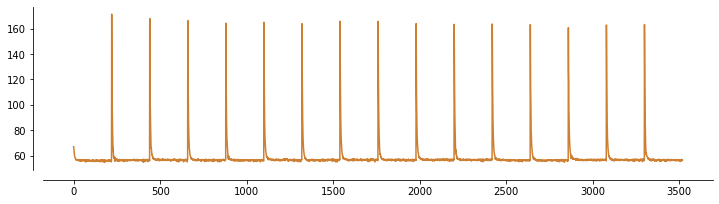

In [421]:
glm.plot_array(ts_mean)

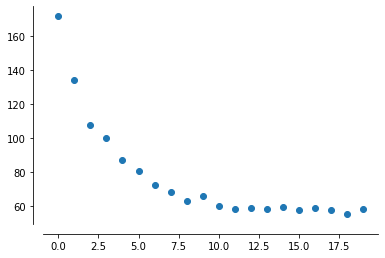

In [422]:
xx = np.arange(0,20)
yy = ts_mean[220:220+xx.shape[0]]

plt.scatter(xx,yy)
sns.despine(offset=10)

In [423]:
# https://machinelearningmastery.com/curve-fitting-with-python/
# https://stackoverflow.com/questions/3938042/fitting-exponential-decay-with-no-initial-guessing
# https://stackoverflow.com/questions/19406049/extrapolating-data-with-numpy-python/19432618
# https://newbedev.com/extrapolating-data-with-numpy-python

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, xx, yy)

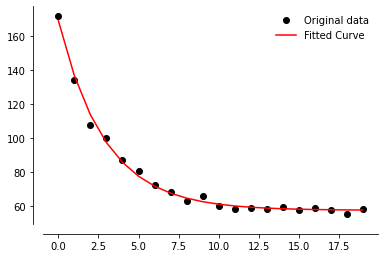

f(x) = 111.15 * np.exp(-0.34*x) + 58.0


In [424]:
plt.figure()
plt.plot(xx, yy, 'ko', label="Original data")
plt.plot(xx, func(xx, *popt), 'r-', label="Fitted Curve")
plt.legend(frameon=False)
sns.despine(offset=10)
plt.show()

print(f"f(x) = {round(popt[0],2)} * np.exp(-{round(popt[1],2)}*x) + {round(popt[2])}")

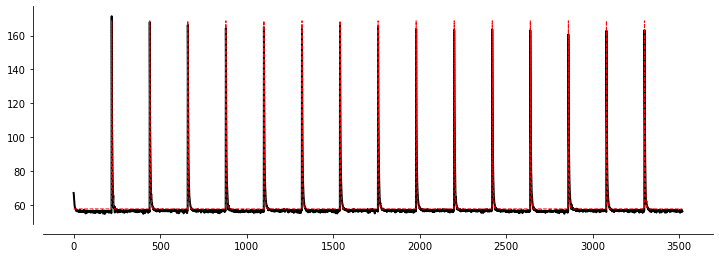

In [425]:
section = np.tile(np.r_[func(xx, *popt),np.repeat(popt[2],220-len(xx))],fatnav_volumes.shape[0])
ts_decay = np.r_[np.repeat(popt[2],220), section]

plt.figure(figsize=(12,4))
plt.plot(ts_mean, color='k',lw=2)
plt.plot(ts_decay, color='r', ls='--', lw=1)
sns.despine(offset=10)
plt.show()

ts_decay.shape

assert ts_decay.shape[0] == ts_mean.shape[0]

In [426]:
from scipy.interpolate import interp1d

fst = ts_mean[204:219][np.newaxis,...]
lin_fit = interp1d(np.arange(0,fatnav_volumes[0]), fst, fill_value='extrapolate')
insert_ext = np.squeeze(lin_fit(np.arange(0,15)).T)

In [427]:
new = np.vstack([ts_mean[:219][...,np.newaxis],
                 insert_ext[...,np.newaxis],
                 ts_mean[219:][...,np.newaxis]])


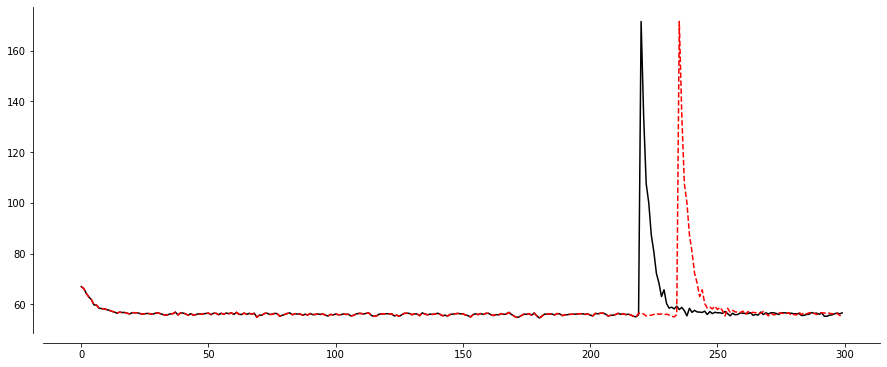

In [428]:
fig,axs = plt.subplots(1,1,figsize=(15,6))

axs.plot(ts_mean[:300], color='k')
axs.plot(new[:300], color='r', ls='--')

sns.despine(offset=10)

In [429]:
new = np.copy(ts_mean)
new_dyn_start = {}
frame_per_dyn = 220

if new.ndim == 1:
    new = new[np.newaxis,...]

# loop through fatnavs
for ix,ii in enumerate(fatnav_volumes):
    
    # get current dynamic and associated volumes
    dyn = ix+1
    vol = frame_per_dyn*dyn
    
    if dyn == 1:
        period = [vol-ii,vol]
    else:
        # here we also need to account for the already inserted values from earlier dynamics
        vol += fatnav_volumes[ix-1]
        period = [vol-ii,vol]
        
#     print(f"current dynamic = {ii}")
    
    # interpolate
    fst = new[:,period[0]:period[1]]
    
    if fst.ndim == 1:
        fst = fst[np.newaxis,...]
        
    lin_fit = interp1d(np.arange(0,ii), fst, fill_value='extrapolate')
    insert_ext = np.squeeze(lin_fit(np.arange(0,ii)).T)
    
    if insert_ext.ndim == 1:
        insert_ext = insert_ext[np.newaxis,...]
    
    if dyn == 1:
        add = fatnav_volumes[ix]
    else:
        add = np.sum(fatnav_volumes[:ix])

    new_dyn_start[dyn] = vol+add
    print(f"adding {add}; new vol = {new_dyn_start[dyn]}")
#     print(new[:,:vol].shape)
    # add
    new = np.hstack([new[:,:vol],
                     insert_ext,
                     new[:,vol:]])
    
new = new.T

adding 15; new vol = 235
adding 15; new vol = 470
adding 30; new vol = 705
adding 45; new vol = 940
adding 60; new vol = 1175
adding 75; new vol = 1410
adding 90; new vol = 1645
adding 105; new vol = 1880
adding 120; new vol = 2115
adding 135; new vol = 2350
adding 150; new vol = 2585
adding 165; new vol = 2820
adding 180; new vol = 3055
adding 195; new vol = 3290
adding 210; new vol = 3525


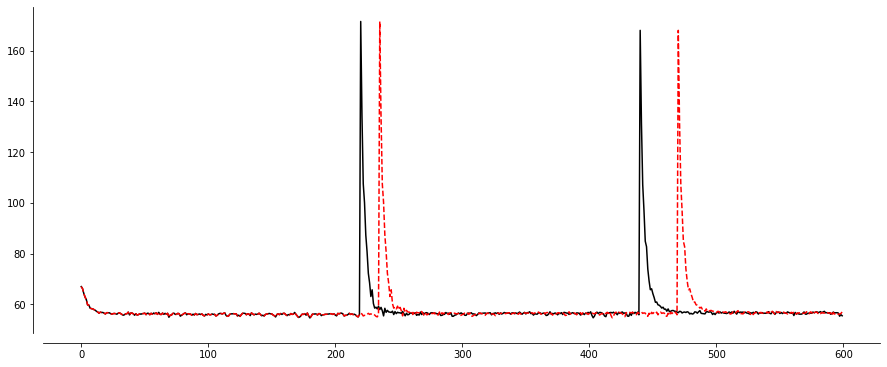

In [439]:
test = np.full_like(new, baseline)

if ts_mean.ndim == 1:
    ts_mean_ax = ts_mean[...,np.newaxis]
    
test[:ts_mean_ax.shape[0],:] = ts_mean_ax

fig,axs = plt.subplots(1,1,figsize=(15,6))

axs.plot(test[:600], color='k')
axs.plot(new[:600], color='r', ls='--')

sns.despine(offset=10)

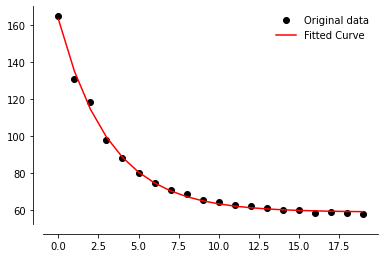

f(x) = 104.35 * np.exp(-0.31*x) + 59.0


In [432]:
xx = np.arange(0,20)
yy = new[new_dyn_start[5]:new_dyn_start[5]+xx.shape[0],:]

if yy.ndim > 1:
    yy = np.squeeze(yy)
    
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, xx, yy)

plt.figure()
plt.plot(xx, yy, 'ko', label="Original data")
plt.plot(xx, func(xx, *popt), 'r-', label="Fitted Curve")
plt.legend(frameon=False)
sns.despine(offset=10)
plt.show()

print(f"f(x) = {round(popt[0],2)} * np.exp(-{round(popt[1],2)}*x) + {round(popt[2])}")

f(x) = 111.46 * np.exp(-0.34*x) + 57.0
f(x) = 106.12 * np.exp(-0.33*x) + 58.0
f(x) = 106.09 * np.exp(-0.3*x) + 57.0
f(x) = 104.42 * np.exp(-0.31*x) + 57.0
f(x) = 104.92 * np.exp(-0.3*x) + 58.0
f(x) = 103.7 * np.exp(-0.3*x) + 57.0
f(x) = 105.34 * np.exp(-0.3*x) + 58.0
f(x) = 106.22 * np.exp(-0.3*x) + 57.0
f(x) = 102.73 * np.exp(-0.32*x) + 58.0
f(x) = 104.46 * np.exp(-0.31*x) + 57.0
f(x) = 103.2 * np.exp(-0.3*x) + 57.0
f(x) = 102.71 * np.exp(-0.3*x) + 57.0
f(x) = 100.88 * np.exp(-0.29*x) + 58.0
f(x) = 102.29 * np.exp(-0.31*x) + 59.0
f(x) = 104.82 * np.exp(-0.32*x) + 57.0


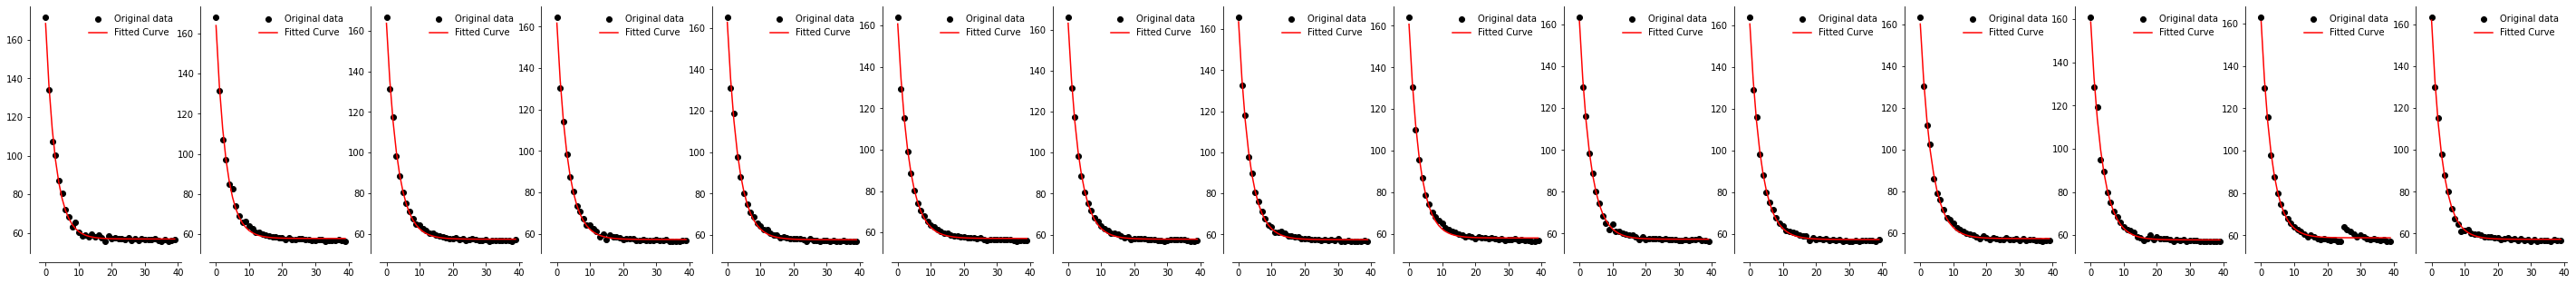

In [466]:
get_model_fits_per_dyn = {}
decay_regress = np.zeros_like(new)
decay_regress[:new_dyn_start[1]] = baseline

fig,axs = plt.subplots(1,fatnav_volumes.shape[0], figsize=(50,5))

for ix,ii in enumerate(fatnav_volumes):
    
    dyn = ix+1
    xx = np.arange(0,40)
    yy = new[new_dyn_start[dyn]:new_dyn_start[dyn]+xx.shape[0],:]

    if yy.ndim > 1:
        yy = np.squeeze(yy)

    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    popt, pcov = curve_fit(func, xx, yy)
    model_fit = func(xx, *popt)
    get_model_fits_per_dyn[ix+1] = model_fit
    print(f"f(x) = {round(popt[0],2)} * np.exp(-{round(popt[1],2)}*x) + {round(popt[2])}")
    
    axs[ix].plot(xx, yy, 'ko', label="Original data")
    axs[ix].plot(xx, func(xx, *popt), 'r-', label="Fitted Curve")
    axs[ix].legend(frameon=False)
    sns.despine(offset=10)
    
    base = np.full_like(new[:235-xx.shape[0],:], popt[2])
    if base.ndim > 1:
        base = np.squeeze(base)
        
    section = np.r_[model_fit, base]
    
    if section.ndim == 1:
        section = section[...,np.newaxis]
    
    if dyn < len(new_dyn_start):
        decay_regress[new_dyn_start[dyn]:new_dyn_start[dyn+1],:] = section
    else:
        decay_regress[new_dyn_start[dyn]:,:] = section[:220,:]

    
plt.show()

    

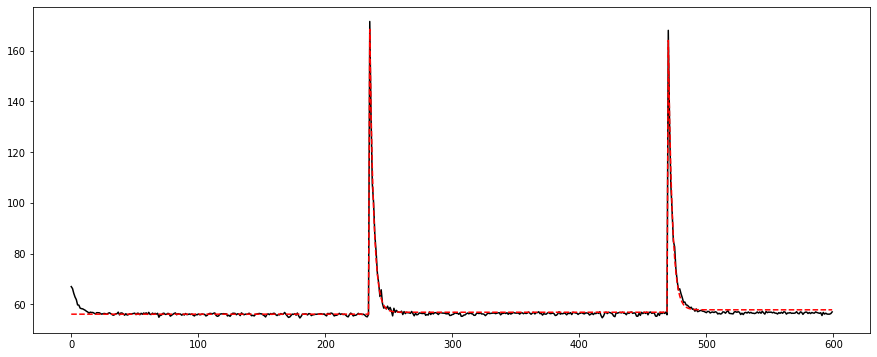

In [467]:
fig,axs = plt.subplots(1,1,figsize=(15,6))

axs.plot(new[:600], color='k')
axs.plot(decay_regress[:600], color='r', ls='--')

In [342]:
section = np.tile(np.r_[func(xx, *popt),np.repeat(popt[2],220-len(xx))],fatnav_volumes.shape[0])
ts_decay = np.r_[np.repeat(popt[2],220), section]

plt.figure(figsize=(12,4))
plt.plot(ts_mean, color='k',lw=2)
plt.plot(ts_decay, color='r', ls='--', lw=1)
sns.despine(offset=10)
plt.show()

ts_decay.shape

assert ts_decay.shape[0] == ts_mean.shape[0]

(20, 1)